# 株価予測

- [超簡単Pythonで株価予測（LightGBM 利用）機械学習](https://note.com/10mohi6/n/n4b1196fea816)
- [超簡単Pythonで株価予測（Optuna・LightGBM 利用）ハイパーパラメータ自動最適化](https://note.com/10mohi6/n/n46d1bb0267b7)

In [1]:
!pip install scikit-learn lightgbm pandas-datareader optuna mplfinance

In [2]:
!pip install graphviz japanize-matplotlib

In [3]:
# 分析用データのダウンロード
import datetime
import pandas_datareader as data

start = datetime.date(2010, 1, 1)
end = datetime.date(2021, 12, 31)
df = data.DataReader('6701.T', 'yahoo', start, end)
df.to_csv('6701.csv')

In [4]:
# pandasのインポート
import pandas as pd

In [5]:
# データの読み込み
df = pd.read_csv('6701.csv')
# データフレームの表示
df

,Date,High,Low,Open,Close,Volume,Adj Close
0,2010-01-04,2440.0,2380.0,2380.0,2420.0,1386200.0,2027.385376
1,2010-01-05,2470.0,2420.0,2450.0,2430.0,2641400.0,2035.762939
2,2010-01-06,2430.0,2430.0,2430.0,2430.0,2662100.0,2035.762939
3,2010-01-07,2450.0,2420.0,2430.0,2440.0,1938600.0,2044.140381
4,2010-01-08,2500.0,2440.0,2470.0,2450.0,3499400.0,2052.517822
...,...,...,...,...,...,...,...
2951,2021-12-24,5300.0,5240.0,5300.0,5260.0,520900.0,5260.000000
2952,2021-12-27,5290.0,5180.0,5280.0,5200.0,527600.0,5200.000000
2953,2021-12-28,5240.0,5190.0,5200.0,5240.0,805700.0,5240.000000
2954,2021-12-29,5310.0,5250.0,5250.0,5310.0,727100.0,5310.000000


In [6]:
# 各カラムの詳細確認
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       2956 non-null   object 
 1   High       2956 non-null   float64
 2   Low        2956 non-null   float64
 3   Open       2956 non-null   float64
 4   Close      2956 non-null   float64
 5   Volume     2956 non-null   float64
 6   Adj Close  2956 non-null   float64
dtypes: float64(6), object(1)
memory usage: 161.8+ KB


In [7]:
# Dateのデータ型を'datetime'型へ変更
df['Date'] = pd.to_datetime(df['Date'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2956 entries, 0 to 2955
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   Date       2956 non-null   datetime64[ns]
 1   High       2956 non-null   float64       
 2   Low        2956 non-null   float64       
 3   Open       2956 non-null   float64       
 4   Close      2956 non-null   float64       
 5   Volume     2956 non-null   float64       
 6   Adj Close  2956 non-null   float64       
dtypes: datetime64[ns](1), float64(6)
memory usage: 161.8 KB


In [8]:
# 曜日情報を追加（月曜:0, 火曜:1, 水曜:2, 木曜:3, 金曜:4, 土曜:5, 日曜:6）
df['weekday'] = df['Date'].dt.weekday
df

,Date,High,Low,Open,Close,Volume,Adj Close,weekday
0,2010-01-04,2440.0,2380.0,2380.0,2420.0,1386200.0,2027.385376,0
1,2010-01-05,2470.0,2420.0,2450.0,2430.0,2641400.0,2035.762939,1
2,2010-01-06,2430.0,2430.0,2430.0,2430.0,2662100.0,2035.762939,2
3,2010-01-07,2450.0,2420.0,2430.0,2440.0,1938600.0,2044.140381,3
4,2010-01-08,2500.0,2440.0,2470.0,2450.0,3499400.0,2052.517822,4
...,...,...,...,...,...,...,...,...
2951,2021-12-24,5300.0,5240.0,5300.0,5260.0,520900.0,5260.000000,4
2952,2021-12-27,5290.0,5180.0,5280.0,5200.0,527600.0,5200.000000,0
2953,2021-12-28,5240.0,5190.0,5200.0,5240.0,805700.0,5240.000000,1
2954,2021-12-29,5310.0,5250.0,5250.0,5310.0,727100.0,5310.000000,2


In [9]:
# 初めの月曜日となる1965/1/4を基準に週を追加
from datetime import datetime
from datetime import timedelta
start = datetime(1965, 1, 4)
df['weeks'] = (df['Date'] - start) // timedelta(weeks=1)
df

,Date,High,Low,Open,Close,Volume,Adj Close,weekday,weeks
0,2010-01-04,2440.0,2380.0,2380.0,2420.0,1386200.0,2027.385376,0,2348
1,2010-01-05,2470.0,2420.0,2450.0,2430.0,2641400.0,2035.762939,1,2348
2,2010-01-06,2430.0,2430.0,2430.0,2430.0,2662100.0,2035.762939,2,2348
3,2010-01-07,2450.0,2420.0,2430.0,2440.0,1938600.0,2044.140381,3,2348
4,2010-01-08,2500.0,2440.0,2470.0,2450.0,3499400.0,2052.517822,4,2348
...,...,...,...,...,...,...,...,...,...
2951,2021-12-24,5300.0,5240.0,5300.0,5260.0,520900.0,5260.000000,4,2972
2952,2021-12-27,5290.0,5180.0,5280.0,5200.0,527600.0,5200.000000,0,2973
2953,2021-12-28,5240.0,5190.0,5200.0,5240.0,805700.0,5240.000000,1,2973
2954,2021-12-29,5310.0,5250.0,5250.0,5310.0,727100.0,5310.000000,2,2973


In [10]:
# カラムの並び替え
df = df[['Date', 'weeks', 'weekday', 'High', 'Low', 'Open', 'Close', 'Volume']]
df

,Date,weeks,weekday,High,Low,Open,Close,Volume
0,2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0
1,2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0
2,2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0
3,2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0
4,2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0
...,...,...,...,...,...,...,...,...
2951,2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0
2952,2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0
2953,2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0
2954,2021-12-29,2973,2,5310.0,5250.0,5250.0,5310.0,727100.0


In [11]:
# 日付をインデックスにセット
df.set_index(keys='Date', inplace=True)
df

# データの並び替え
df.sort_values(by='Date', ascending=True, inplace=True)

<ipython-input-11-762f61eefcf0>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.sort_values(by='Date', ascending=True, inplace=True)


In [12]:
# カラム情報を1行上にずらしたデータフレームを作成する
#df_shift = df.shift(-1)
#df_shift

In [13]:
# 翌日の終値と本日の終値の差分を追加する
#df['delta_Close'] = df_shift['Close'] - df['Close']
df['delta_Close'] = df.Close.diff()
# 3日後の終値と本日の終値の差分を追加する
#df['delta_Close'] = df.Close.diff(3)
df

<ipython-input-13-84338e19e547>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['delta_Close'] = df.Close.diff()


,weeks,weekday,High,Low,Open,Close,Volume,delta_Close
Date,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0
...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0


In [14]:
# 目的変数Upを追加する（翌日の始値が上がる場合1、それ以外は0とする）
df['Up'] = 0
#df['Up'][df['delta_Close'] > 0] = 1
df['Up'] = df['delta_Close'].apply(lambda x: 1 if x > 0 else 0).shift(-1)
# 目的変数の算出に用いた列を削除する
#df = df.drop('delta_Close', axis=1)
df

,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up
Date,,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0
...,...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0


# データの全体像をつかむ

<AxesSubplot:xlabel='Date'>

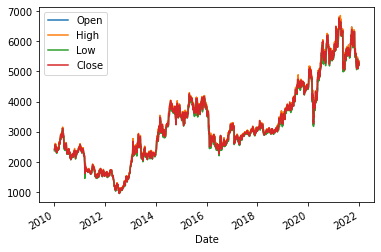

In [15]:
# 'Open', 'High', 'Low', 'Close'グラフ化のためにカラム抽出
df_new = df[['Open', 'High', 'Low', 'Close']]

# matplotlibのインポート
from matplotlib import pyplot as plt
%matplotlib inline

# 時系列折れ線グラフの作成
df_new.plot(kind='line')

# 特徴量を追加する

In [16]:
# 終値の前日比の追加
df_shift = df.shift(1)

df['Close_ratio'] = (df['Close'] - df_shift['Close']) / df_shift['Close']
df

,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up,Close_ratio
Date,,,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0,NaN
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0,0.004132
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0,0.000000
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0,0.004115
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0,0.004098
...,...,...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0,-0.001898
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0,-0.011407
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0,0.007692


In [17]:
# 始値と終値の差分を追加
df['Body'] = df['Open'] - df['Close']
df

,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up,Close_ratio,Body
Date,,,,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0,NaN,-40.0
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0,0.004132,20.0
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0,0.000000,0.0
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0,0.004115,-10.0
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0,0.004098,20.0
...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0,-0.001898,40.0
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0,-0.011407,80.0
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0,0.007692,-40.0


In [18]:
# 勢力指数（Force Index）を追加
df['Force_Index'] = df['Close'] * df['Volume']
df

,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up,Close_ratio,Body,Force_Index
Date,,,,,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0,NaN,-40.0,3.354604e+09
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0,0.004132,20.0,6.418602e+09
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0,0.000000,0.0,6.468903e+09
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0,0.004115,-10.0,4.730184e+09
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0,0.004098,20.0,8.573530e+09
...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0,-0.001898,40.0,2.739934e+09
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0,-0.011407,80.0,2.743520e+09
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0,0.007692,-40.0,4.221868e+09


In [19]:
# TA-Libのインポート
import talib

# テクニカル指標
def add_technical_features(df):
    # Simple Moving Average
    close = df['Close']
    df['sma3'] = talib.SMA(close, timeperiod=3)
    df['sma5'] = talib.SMA(close, timeperiod=5)
    df['sma25'] = talib.SMA(close, timeperiod=25)
    df['sma50'] = talib.SMA(close, timeperiod=50)
    df['sma75'] = talib.SMA(close, timeperiod=75)
    df['sma100'] = talib.SMA(close, timeperiod=100)
    # Bollinger Bands
    df['upper1'], middle, df['lower1'] = talib.BBANDS(close, timeperiod=25, nbdevup=1, nbdevdn=1, matype=0)
    df['upper2'], middle, df['lower2'] = talib.BBANDS(close, timeperiod=25, nbdevup=2, nbdevdn=2, matype=0)
    df['upper3'], middle, df['lower3'] = talib.BBANDS(close, timeperiod=25, nbdevup=3, nbdevdn=3, matype=0)
    # MACD - Moving Average Convergence/Divergence
    df['macd'], df['macdsignal'], df['macdhist'] = talib.MACD(close, fastperiod=12, slowperiod=26, signalperiod=9)
    # RSI - Relative Strength Index
    df['rsi9'] = talib.RSI(close, timeperiod=9)
    df['rsi14'] = talib.RSI(close, timeperiod=14)
    return df

In [20]:
# テクニカル指標を追加
df = add_technical_features(df)
df

,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up,Close_ratio,...,lower1,upper2,lower2,upper3,lower3,macd,macdsignal,macdhist,rsi9,rsi14
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0,0.004132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0,0.004115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0,0.004098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0,-0.001898,...,5160.785966,5434.428068,5069.571932,5525.642102,4978.357898,-65.117661,-86.345627,21.227967,47.490766,44.765348
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0,-0.011407,...,5157.221837,5431.956327,5065.643673,5523.534490,4974.065510,-65.580715,-82.192645,16.611930,41.800209,41.416128
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0,0.007692,...,5156.110984,5430.578031,5064.621969,5522.067047,4973.132953,-62.005265,-78.155169,16.149904,46.599247,44.402543


In [21]:
# 欠損値を列の1つ手前の値で埋める
df = df.fillna(method='ffill')
df

,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up,Close_ratio,...,lower1,upper2,lower2,upper3,lower3,macd,macdsignal,macdhist,rsi9,rsi14
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0,0.004132,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0,0.000000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0,0.004115,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0,0.004098,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0,-0.001898,...,5160.785966,5434.428068,5069.571932,5525.642102,4978.357898,-65.117661,-86.345627,21.227967,47.490766,44.765348
2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0,-0.011407,...,5157.221837,5431.956327,5065.643673,5523.534490,4974.065510,-65.580715,-82.192645,16.611930,41.800209,41.416128
2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0,0.007692,...,5156.110984,5430.578031,5064.621969,5522.067047,4973.132953,-62.005265,-78.155169,16.149904,46.599247,44.402543


In [22]:
# 分析用データのSave
df.to_csv('6701_wFeatures.csv')

In [23]:
# データの読み込み
df = pd.read_csv('6701_wFeatures.csv')
# データフレームの表示
df

,Date,weeks,weekday,High,Low,Open,Close,Volume,delta_Close,Up,...,lower1,upper2,lower2,upper3,lower3,macd,macdsignal,macdhist,rsi9,rsi14
0,2010-01-04,2348,0,2440.0,2380.0,2380.0,2420.0,1386200.0,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2010-01-05,2348,1,2470.0,2420.0,2450.0,2430.0,2641400.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2010-01-06,2348,2,2430.0,2430.0,2430.0,2430.0,2662100.0,0.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2010-01-07,2348,3,2450.0,2420.0,2430.0,2440.0,1938600.0,10.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2010-01-08,2348,4,2500.0,2440.0,2470.0,2450.0,3499400.0,10.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2951,2021-12-24,2972,4,5300.0,5240.0,5300.0,5260.0,520900.0,-10.0,0.0,...,5160.785966,5434.428068,5069.571932,5525.642102,4978.357898,-65.117661,-86.345627,21.227967,47.490766,44.765348
2952,2021-12-27,2973,0,5290.0,5180.0,5280.0,5200.0,527600.0,-60.0,1.0,...,5157.221837,5431.956327,5065.643673,5523.534490,4974.065510,-65.580715,-82.192645,16.611930,41.800209,41.416128
2953,2021-12-28,2973,1,5240.0,5190.0,5200.0,5240.0,805700.0,40.0,1.0,...,5156.110984,5430.578031,5064.621969,5522.067047,4973.132953,-62.005265,-78.155169,16.149904,46.599247,44.402543
2954,2021-12-29,2973,2,5310.0,5250.0,5250.0,5310.0,727100.0,70.0,0.0,...,5160.910984,5435.378031,5069.421969,5526.867047,4977.932953,-52.913328,-73.106801,20.193473,54.057513,49.275704
